[View in Colaboratory](https://colab.research.google.com/github/abhinavrk/GoogleColabMusings/blob/master/seq2seq_translation_assignment4.ipynb)

In [2]:
loaded = False

if not loaded:
  # http://pytorch.org/
  from os import path
  from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
  platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

  accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

  !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

  import torch
  loaded = True

  !wget https://download.pytorch.org/tutorial/data.zip
  !unzip data.zip

--2018-07-19 18:30:00--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.80.66, 13.32.80.22, 13.32.80.53, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.80.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  5.35MB/s    in 0.5s    

2018-07-19 18:30:01 (5.35 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
%matplotlib inline

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['ils sont chanteurs .', 'they are singers .']


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, enc_outputs):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, enc_outputs

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

In [22]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(
    hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

attn_decoder_losses = trainIters(encoder1, attn_decoder1, 75000, print_every=1000)

0m 51s (- 63m 4s) (1000 1%) 3.5203
1m 34s (- 57m 14s) (2000 2%) 3.0172
2m 17s (- 54m 53s) (3000 4%) 2.7740
3m 0s (- 53m 23s) (4000 5%) 2.6507
3m 44s (- 52m 16s) (5000 6%) 2.5391
4m 27s (- 51m 15s) (6000 8%) 2.4581
5m 11s (- 50m 21s) (7000 9%) 2.4087
5m 54s (- 49m 31s) (8000 10%) 2.3230
6m 38s (- 48m 41s) (9000 12%) 2.2588
7m 21s (- 47m 50s) (10000 13%) 2.1400
8m 5s (- 47m 5s) (11000 14%) 2.0858
8m 49s (- 46m 18s) (12000 16%) 2.0196
9m 33s (- 45m 33s) (13000 17%) 2.0159
10m 17s (- 44m 50s) (14000 18%) 1.9558
11m 0s (- 44m 3s) (15000 20%) 1.8696
11m 44s (- 43m 17s) (16000 21%) 1.8242
12m 28s (- 42m 35s) (17000 22%) 1.8154
13m 12s (- 41m 50s) (18000 24%) 1.7608
13m 56s (- 41m 6s) (19000 25%) 1.6518
14m 41s (- 40m 23s) (20000 26%) 1.6354
15m 24s (- 39m 37s) (21000 28%) 1.6389
16m 8s (- 38m 53s) (22000 29%) 1.5939
16m 52s (- 38m 9s) (23000 30%) 1.5328
17m 36s (- 37m 25s) (24000 32%) 1.4939
18m 20s (- 36m 41s) (25000 33%) 1.5108
19m 5s (- 35m 57s) (26000 34%) 1.4267
19m 49s (- 35m 14s) (2700

54m 14s (- 1m 29s) (73000 97%) 0.5746
55m 0s (- 0m 44s) (74000 98%) 0.5571
55m 45s (- 0m 0s) (75000 100%) 0.5792


In [29]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder2 = DecoderRNN(
    hidden_size, output_lang.n_words).to(device)

decoder_losses = trainIters(encoder2, decoder2, 75000, print_every=1000)

0m 39s (- 48m 31s) (1000 1%) 3.5003
1m 8s (- 41m 49s) (2000 2%) 3.0756
1m 38s (- 39m 20s) (3000 4%) 2.8425
2m 8s (- 37m 52s) (4000 5%) 2.7004
2m 37s (- 36m 48s) (5000 6%) 2.6430
3m 8s (- 36m 3s) (6000 8%) 2.6138
3m 38s (- 35m 21s) (7000 9%) 2.4862
4m 8s (- 34m 40s) (8000 10%) 2.4026
4m 38s (- 34m 3s) (9000 12%) 2.3019
5m 9s (- 33m 31s) (10000 13%) 2.3281
5m 39s (- 32m 57s) (11000 14%) 2.2025
6m 10s (- 32m 23s) (12000 16%) 2.1558
6m 40s (- 31m 50s) (13000 17%) 2.0995
7m 10s (- 31m 16s) (14000 18%) 2.0257
7m 41s (- 30m 46s) (15000 20%) 1.9645
8m 11s (- 30m 14s) (16000 21%) 1.9234
8m 42s (- 29m 41s) (17000 22%) 1.8854
9m 12s (- 29m 10s) (18000 24%) 1.8239
9m 43s (- 28m 40s) (19000 25%) 1.7321
10m 14s (- 28m 9s) (20000 26%) 1.7338
10m 44s (- 27m 38s) (21000 28%) 1.6929
11m 15s (- 27m 6s) (22000 29%) 1.6851
11m 46s (- 26m 36s) (23000 30%) 1.6020
12m 16s (- 26m 5s) (24000 32%) 1.5988
12m 47s (- 25m 34s) (25000 33%) 1.5264
13m 17s (- 25m 3s) (26000 34%) 1.4719
13m 48s (- 24m 33s) (27000 36%) 

37m 55s (- 1m 2s) (73000 97%) 0.5734
38m 27s (- 0m 31s) (74000 98%) 0.5132
38m 59s (- 0m 0s) (75000 100%) 0.4997


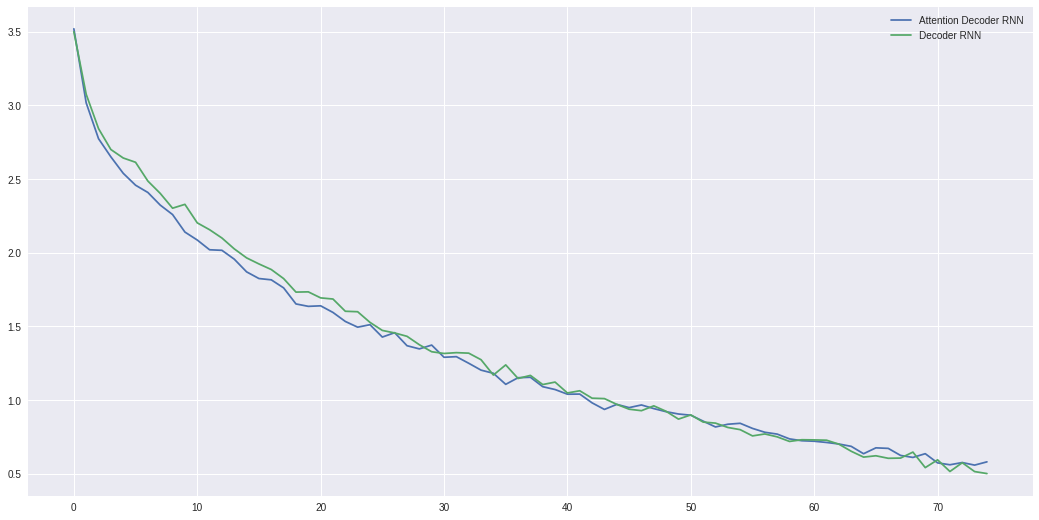

In [33]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 9]

attn_decoder_losses_avg = []
decoder_losses_avg = []

for i in range(0, len(attn_decoder_losses), 10):
  attn_decoder_losses_avg.append(sum(attn_decoder_losses[i:i+10])/10.)
  decoder_losses_avg.append(sum(decoder_losses[i:i+10])/10.)

plt.figure()
plt.plot(attn_decoder_losses_avg, label='Attention Decoder RNN')
plt.plot(decoder_losses_avg, label='Decoder RNN')
plt.legend()